In [1]:
import h5py
import numpy as np
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


f = h5py.File('../dummy_data/jax_test/inputdata.h5', "r")
order = 3
bin_name = '/func0#0'


# f = h5py.File('inputdata.h5', "r")
# order = 3
# bin_name = '/ATLAS_2019_I1736531/d01-x01-y01[AUX_isr:murfac=0.5]#0'

print(f.keys())

pnames = [str(p) for p in f.get('params').attrs["names"]]
print("parameter names: ", pnames)

observables = np.unique([x.decode().split("#")[0] for x in f.get("index")[:]])
print(len(observables), " observables")
print(observables[0:10])
print(f.get("index")[0:10])

# key bin names to the array indexes(of values) with binids(in index) matching thier bin
index = {}
II = [x.decode() for x in f.get("index")[:]]
print(II[0:10])
[index.setdefault(bin.split('#')[0], []).append(i) for i,bin in enumerate(II)]
index = {k : np.array(index[k]) for k in index.keys()}

<KeysViewHDF5 ['errors', 'index', 'params', 'runs', 'values', 'xmax', 'xmin']>
parameter names:  ["b'a'", "b'b'"]
2  observables
['/func0' '/func1']
[b'/func0#0' b'/func0#1' b'/func0#2' b'/func0#3' b'/func0#4' b'/func0#5'
 b'/func0#6' b'/func0#7' b'/func0#8' b'/func0#9']
['/func0#0', '/func0#1', '/func0#2', '/func0#3', '/func0#4', '/func0#5', '/func0#6', '/func0#7', '/func0#8', '/func0#9']


In [2]:
print(f.keys())
print(list(f['runs']))
print(list(f['params']))

<KeysViewHDF5 ['errors', 'index', 'params', 'runs', 'values', 'xmax', 'xmin']>
[b'../MC/000000', b'../MC/000001', b'../MC/000002', b'../MC/000003', b'../MC/000004', b'../MC/000005', b'../MC/000006', b'../MC/000007', b'../MC/000008', b'../MC/000009', b'../MC/000010', b'../MC/000011', b'../MC/000012', b'../MC/000013', b'../MC/000014', b'../MC/000015', b'../MC/000016', b'../MC/000017', b'../MC/000018', b'../MC/000019', b'../MC/000020', b'../MC/000021', b'../MC/000022', b'../MC/000023', b'../MC/000024', b'../MC/000025', b'../MC/000026', b'../MC/000027', b'../MC/000028', b'../MC/000029', b'../MC/000030', b'../MC/000031', b'../MC/000032', b'../MC/000033', b'../MC/000034', b'../MC/000035', b'../MC/000036', b'../MC/000037', b'../MC/000038', b'../MC/000039', b'../MC/000040', b'../MC/000041']
[array([ 1.29908323, -1.14741315]), array([ 1.58822832, -0.96917223]), array([ 1.38118907, -0.80663435]), array([ 1.34155249, -1.10053236]), array([ 1.64310488, -1.14071321]), array([ 1.70596303, -1.1418015

Helper funcs

In [6]:
def grlex_eval(dim, order, coeff, x):
    np.flip(x)
    term = np.zeros(dim)
    sum = 0
    for i in range(numCoeffsPoly(dim, order)):
        sum += coeff[i]*(x**term).prod()
        # print(coeff[i], ' * ', x**term, ' term ', term)
        term = mono_next_grlex(dim, term)
    print(sum)
    return sum.sum()
def numCoeffsPoly(dim, order):
    """
    Number of coefficients a dim-dimensional polynomial of order order has.
    """
    ntok = 1
    r = min(order, dim)
    for i in range(r):
        ntok = ntok * (dim + order - i) / (i + 1)
    return int(ntok)
def mono_next_grlex(m, x):
    #  Author:
    #
    #    John Burkardt
    #
    #     TODO --- figure out the licensing thing https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html

    #  Find I, the index of the rightmost nonzero entry of X.
    i = 0
    for j in range(m, 0, -1):
        if 0 < x[j-1]:
            i = j
            break

    #  set T = X(I)
    #  set X(I) to zero,
    #  increase X(I-1) by 1,
    #  increment X(M) by T-1.
    if i == 0:
        x[m-1] = 1
        return x
    elif i == 1:
        t = x[0] + 1
        im1 = m
    elif 1 < i:
        t = x[i-1]
        im1 = i - 1

    x[i-1] = 0
    x[im1-1] = x[im1-1] + 1
    x[m-1] = x[m-1] + t - 1

    return x

def vandermonde_jax(params, order):
    """
    Construct the Vandermonde matrix.
    """
    try:
        dim = len(params[0])
    except:
        dim = 1

    #We will take params to the power of s element-wise
    if dim == 1:
        s = jnp.array(range(order+1))
    else:
        term_list = [[0]*dim]
        for i in range(1, numCoeffsPoly(dim, order)):
            term_list.append(mono_next_grlex(dim, term_list[-1][:]))
        s = jnp.array(term_list)
    
    if len(params[0]) == 1:
        V = jnp.zeros((len(params), numCoeffsPoly(dim, order)), dtype=jnp.float64)
        for a, p in enumerate(params): 
            V = V.at[a].set(p**s)
        return V
    else:
        V = jnp.power(params, s[:, jnp.newaxis])
        return jnp.prod(V, axis=2).T


Original monomial apprentice code for tests

In [7]:
import numpy as np
from numba import jit, njit

# @njit
def mono_next_grlex(m, x):
    #  Author:
    #
    #    John Burkardt
    #
    #     TODO --- figure out the licensing thing https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html

    #  Find I, the index of the rightmost nonzero entry of X.
    i = 0
    for j in range(m, 0, -1):
        if 0 < x[j-1]:
            i = j
            break

    #  set T = X(I)
    #  set X(I) to zero,
    #  increase X(I-1) by 1,
    #  increment X(M) by T-1.
    if i == 0:
        x[m-1] = 1
        return x
    elif i == 1:
        t = x[0] + 1
        im1 = m
    elif 1 < i:
        t = x[i-1]
        im1 = i - 1

    x[i-1] = 0
    x[im1-1] = x[im1-1] + 1
    x[m-1] = x[m-1] + t - 1

    return x

def genStruct(dim, mnm):
    while True:
        yield mnm
        mnm =  mono_next_grlex(dim, mnm)

from functools import lru_cache
@lru_cache(maxsize=32)
def monomialStructure(dim, order):
    import numpy as np
    import copy
    from apprentice import tools
    ncmax = tools.numCoeffsPoly(dim, order)
    gen = genStruct(dim, np.zeros(dim))
    structure = np.array([ copy.copy(next(gen)) for _ in range(ncmax)], dtype=int)
    # Dimension one requires some extra treatment when returning ---writing out is fine
    if dim==1:
        return structure.ravel()
    return structure

def recurrence1D(X, structure):
    return X**structure

def recurrence(X, structure):
    """
    Create the parameter combination vector for a particular structure,
    or in more mathy terms, the recurrence relation for X in a monomial basis
    structure.
    """
    return np.prod(X**structure, axis=1, dtype=np.float64)


def recurrence2(X, structure, nnz):
    temp = np.ones((len(structure), len(X)))
    np.power(X, structure, where=nnz, out=(temp))
    return np.prod(temp, axis=1)

def vandermonde(params, order):
    """
    Construct the Vandermonde matrix.
    """
    import numpy as np
    try:
        dim = len(params[0])
    except:
        dim = 1

    from apprentice import tools
    s = monomialStructure(dim, order)
    if len(params[0]) == 1:
        V = np.zeros((len(params), tools.numCoeffsPoly(dim, order)), dtype=np.float64)
        for a, p in enumerate(params): V[a]=recurrence1D(p, s)
        return V
    else:
        V = np.ones((tools.numCoeffsPoly(dim, order), *params.shape), dtype=np.float64)
        np.power(params, s[:, np.newaxis], out=(V), where=s[:, np.newaxis]>0)
        return np.prod(V, axis=2).T

if __name__=="__main__":
    print(monomialStructure(2,3))


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
GPs not available: No module named 'pandas'
[[0 0]
 [0 1]
 [1 0]
 [0 2]
 [1 1]
 [2 0]
 [0 3]
 [1 2]
 [2 1]
 [3 0]]


In [8]:

dim = len(f['params'][0])

obs_name, bin_number = bin_name.split('#')[0], bin_name.split('#')[1] 
X = np.array(f['params'][:], dtype=np.float64)
Y = np.array(f['values'][index[obs_name][int(bin_number)]])
VM = vandermonde_jax(X, order)

# print('should be 0(equal): ', np.subtract(vandermonde(X, order),VM))
# print('params ', X)
# print('values ', Y)
print('vandermonde ', VM)

vandermonde  [[ 1.         -1.14741315  1.29908323  1.31655693 -1.49058517  1.68761724
  -1.51063472  1.71031702 -1.9363942   2.19235525]
 [ 1.         -0.96917223  1.58822832  0.93929481 -1.53926679  2.5224692
  -0.91033845  1.49181462 -2.4447071   4.00625703]
 [ 1.         -0.80663435  1.38118907  0.65065898 -1.11411456  1.90768326
  -0.52484389  0.89868307 -1.53880285  2.63487127]
 [ 1.         -1.10053236  1.34155249  1.21117148 -1.47642193  1.79976309
  -1.3329334   1.62485011 -1.98069752  2.41447666]
 [ 1.         -1.14071321  1.64310488  1.30122662 -1.87431144  2.69979365
  -1.4843264   2.13805182 -3.07969027  4.43604412]
 [ 1.         -1.14180154  1.70596303  1.30371075 -1.9478712   2.91030985
  -1.48857893  2.22408233 -3.32299625  4.964881  ]
 [ 1.         -1.14182621  1.95877674  1.3037671  -2.23658263  3.83680633
  -1.48867544  2.55378867 -4.38096604  7.51544701]
 [ 1.         -0.96768765  1.11554722  0.93641938 -1.07950127  1.2444456
  -0.90616147  1.04462004 -1.20423464  1

polynomial ceofficients:  [  80.62972621  104.38691504  -78.86316804   22.8934713  -118.4974257
    7.38508711  -13.12712689  -45.0598705     9.27279875    0.98583797]


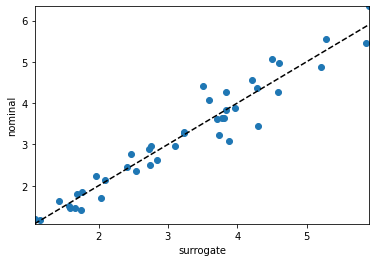

In [9]:
pcoeff, res, rank, s  = np.linalg.lstsq(VM, Y, rcond=None)

# U, S, V = np.linalg.svd(VM)
# # SM dixit: manipulations to solve for the coefficients
# # Given A = U Sigma VT, for A x = b, x = V Sigma^-1 UT b
# temp = np.dot(U.T, Y.T)[0:S.size]
# pcoeff = np.dot(V.T, 1./S * temp)
# epsilon = Y - np.dot(VM, pcoeff)
# resids = np.dot(epsilon.T, epsilon)

def genStruct(dim, mnm):
    while True:
        yield mnm
        mnm =  mono_next_grlex(dim, mnm)

def surrogate(x):
    term = dim*[0]
    powers = []
    for i in range(numCoeffsPoly(dim, order)):
        powers.append(list(term))
        term = mono_next_grlex(dim, term)
    fit = []
    for xi in x:
        fit.append(sum(pcoeff*np.product(xi**powers, axis=1)))
    return fit

# print('polynomial ceofficients compare: ', pcoeff2-pcoeff)
print('polynomial ceofficients: ', pcoeff)
if dim == 1:
    p = np.linspace(X.min(), X.max(), 100)
    plt.plot(p, surrogate(p))
    plt.scatter(X.flatten(), Y)
elif dim == 2:
    fig, ax = plt.subplots()
    plt.scatter(surrogate(X), Y)
    plt.xlabel('surrogate')
    plt.ylabel('nominal')
    ax.autoscale(tight=True)
    xlim = ax.get_xlim()
    plt.plot(xlim, xlim, 'k--')
    # attempted contour pain
    # p_1 = np.linspace(X.min(axis=0)[0], X.max(axis=0)[0], 10)
    # p_2 = np.linspace(X.min(axis=0)[1], X.max(axis=0)[1], 10)
    # P_1, P_2 = np.meshgrid(p_1, p_2)
    # s = np.zeros((len(P_1), len(P_2)))
    # for i in range(len(P_1)):
    #     for j in range(len(P_2)):
    #         # print(P_1[i,j],P_2[i,j])
    #         # print(surrogate([P_1[i,j],P_2[i,j]]))
    #         s[i,j] = surrogate([P_1[i,j],P_2[i,j]])[0]

    # ax = plt.axes(projection='3d')
    # ax.contour3D(P_1, P_2, s, 50, cmap='binary')
    # ax.scatter3D(X[:,0],X[:,1], Y, c=Y, cmap='Greens')
    # # ax.plot3D(p[:,0],p[:,1] , surrogate(p), 'gray')
    

In [10]:
def genStruct(dim, mnm):
    while True:
        yield mnm
        mnm =  mono_next_grlex(dim, mnm)

term = genStruct(dim, [0]*dim)
print(next(term))
print(next(term))

[0, 0]
[0, 1]


In [11]:
f.close()

In [41]:
test = np.array(np.array([[1.5, -1.1], [1.4,-1.1]]))
print(test)
print(np.product(test))
print(np.product(test, axis = 1))

print(np.prod(np.array([1,2]), axis=None))

[[ 1.5 -1.1]
 [ 1.4 -1.1]]
2.5410000000000004
[-1.65 -1.54]
2


In [55]:
def surrogate2(x):
    """
    Takes a list/array of param sets, and returns the surrogate's estimate for their nominal values.
    The length of the highest dimension of the list/array is the number of params.
    """
    x = np.array(x)
    dim = x.shape[-1]
    term_powers = dim*[0]
    numCoeffs = VM.shape[1]
    pvalues = []
    last_axis = None if len(x.shape) == 1 else len(x.shape)-1
    for term_num in range(numCoeffs):
        #appending the value of the term for each param set given
        pvalues.append(pcoeff[term_num]*np.prod(x**term_powers, axis = last_axis))
        term_powers = mono_next_grlex(dim, term_powers)
    #add along first axis to sum the terms for each param set
    return np.sum(pvalues, axis=None if len(x.shape) == 1 else 0)
    
    

print(surrogate)
print(surrogate(np.array([[1.5, -1.1], [1.4,-1.1]])))
print(surrogate2)
print(surrogate2(np.array([1.5, -1.1])))
print(surrogate2(np.array([[[1.5, -1.1], [1.4,-1.1]],[[1.5, -1.1], [1.4,-1.1]]])))

<function surrogate at 0x7f5199de6c10>
[3.4132334400472573, 3.9113615313652454]
<function surrogate2 at 0x7f5184358280>
3.4132334400472573
[[3.41323344 3.91136153]
 [3.41323344 3.91136153]]


Text(0.5, 1.0, "Percent error of the surrogate's predicted values for original data")

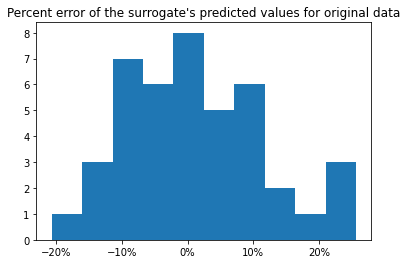

In [ ]:
from matplotlib.ticker import PercentFormatter

surrogate_Y = np.matmul(VM, pcoeff)
percent_error = (surrogate_Y-Y)/Y
plt.hist(percent_error, bins = 10)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percent error of the surrogate\'s predicted values for original data')

In [ ]:
import pickle
f = open('pickle_test', 'wb')
pickle.dump(surrogate, f)
f.close()

f = open('pickle_test', 'rb')
unpickled_func = pickle.load(f)
f.close()

print(surrogate)
print(surrogate(np.array([[1.5, -1]])))
print(unpickled_func)
print(unpickled_func(np.array([[1.5, -1]])))



<function surrogate at 0x7f208c490ca0>
[-241.33532193343083, 14.81547258967436]
<function surrogate at 0x7f208c490ca0>
[3.2048420418561143]
<function surrogate at 0x7f208c490ca0>
[3.2048420418561143]


In [ ]:
import pickle
f = open('pickle_test', 'rb')
unpickled_func = pickle.load(f)
f.close()
print(unpickled_func)
print(unpickled_func(np.array([[1.5, -1]])))


AttributeError: Can't get attribute 'surrogate' on <module '__main__'>